In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
dataset_url = 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'

In [ ]:
data_dir = './chest-xray-pneumonia/chest_xray/chest_xray/'

In [ ]:
import torchvision.transforms as tt
train_tfms = tt.Compose([tt.Resize((128,128)),
                        tt.ToTensor()])

In [ ]:
import os

In [ ]:
train_ds = ImageFolder(os.path.join(data_dir, 'train'), transform=train_tfms)

In [ ]:
train_ds[1][0].shape

torch.Size([3, 128, 128])

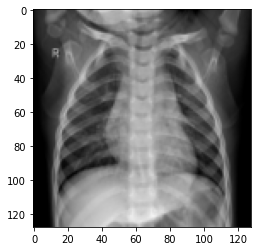

In [ ]:
plt.imshow(train_ds[1][0].permute(1,2,0))

In [ ]:
val_tfms = tt.Compose([tt.Resize((128,128)),
                        tt.ToTensor()])
val_ds = ImageFolder(os.path.join(data_dir, 'test'), transform=val_tfms)

In [ ]:
len(train_ds)

5216

In [ ]:
len(val_ds)

624

In [ ]:
train_ds.classes

['NORMAL', 'PNEUMONIA']

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory =True)
val_dl = DataLoader(train_ds, batch_size*2, num_workers = 4, pin_memory =True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def display_batch(dl):
  for images,labels in dl:
    print(labels)
    fig,ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images,nrow = 16 ).permute(1,2,0)  )
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 0])


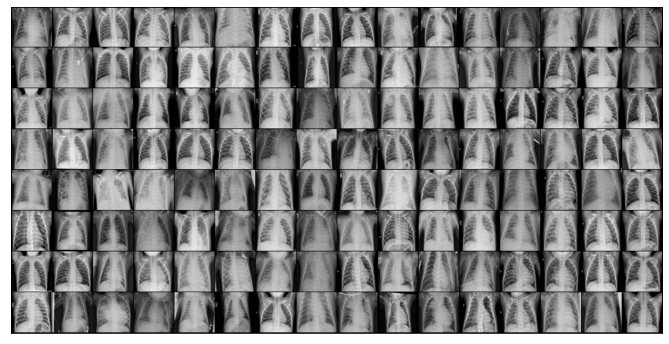

In [ ]:
display_batch(train_dl)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,32,kernel_size = 3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # 64x 64 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 16 x 16

            nn.Flatten(),
            nn.Linear(256*16*16 , 4096 ),
            nn.ReLU(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,16),
            nn.ReLU(),
            nn.Linear(16,2)
        ) 
   
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Model()
model

Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=4096, bias=True)
    (17): ReLU()
    (18): Linear(in_features=4096

In [ ]:
for images, labels in train_dl:
  print('images.shape  : ' ,images.shape )
  out = model(images)
  print('out.shape: ',out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape  :  torch.Size([128, 3, 128, 128])
out.shape:  torch.Size([128, 2])


In [ ]:
out

tensor([[-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0.1682],
        [-0.2486,  0

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
to_device(model,device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Model(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.7505580186843872, 'val_loss': 0.6530965566635132}

In [ ]:
opt_func = torch.optim.Adam 
lr = 0.001
num_epochs = 10

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.5874, val_loss: 0.5618, val_acc: 0.7506
